# Importing Libraries

In [27]:
# For Data Processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import plotly.express as px
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torchbnn as bnn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Import ML Model Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# For Model Evaluation
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc 
from matplotlib import pyplot

# Importing data

In [3]:
colectomy_cci_var = pd.read_csv('./colectomy_cci_var.csv', dtype = 'str')

# Formating datatype

In [4]:
# Set random seed
np.random.seed(42)

# Rename columns
colectomy_cci_var['ptsex'] = colectomy_cci_var['ptsex'].replace({'F': 'female', 'M': 'male'})
colectomy_cci_var['adtype'] = colectomy_cci_var['adtype'].replace({'1': 'emergency', '2': 'urgent', '3': 'elective'})
colectomy_cci_var['adsource'] = colectomy_cci_var['adsource'].replace({'1': 'non_healthcare_facility', '2': 'clinical_referral', '4': 'hospital_transfer', '5': 'snf_icf_transfer', '6': 'healthcare_facility_tranfer', '7': 'emergency_room', '8': 'court_law_enforcement', 'D': 'hospital_unit_transfer', 'E': 'ambulatory_surgery_center'})

colectomy_cci_var['age'] = colectomy_cci_var['age'].astype(int)

colectomy_cci_var['paytype1'] = colectomy_cci_var['paytype1'].fillna('99')

# Drop observations
colectomy_cci_var = colectomy_cci_var[colectomy_cci_var['adsource'] != '9']
colectomy_cci_var = colectomy_cci_var[colectomy_cci_var['adsource'] != 'emergency_room']
colectomy_cci_var = colectomy_cci_var[colectomy_cci_var['adsource'] != 'court_law_enforcement']
colectomy_cci_var = colectomy_cci_var[colectomy_cci_var['adsource'] != 'hospital_unit_transfer']
#print(len(colectomy_cci_var))
colectomy_cci_var = colectomy_cci_var.groupby('pdx').filter(lambda x: len(x) >= 1000)
#print(len(colectomy_cci_var))

# Select Relevant Features
features = ['year', 'ptsex', 'race', 'adtype', 'adsource', 'admdx']
dummy_features = ['year','ptsex', 'race', 'adtype', 'adsource']

# Data Preprocessing
num_secondary_admissions = 10

for i in range(1, num_secondary_admissions + 1):
    sdx = f'sdx{i}'

    features.append(sdx)

    # Replace missing values with the "unknown" category
    colectomy_cci_var[sdx] = colectomy_cci_var[sdx].fillna('unknown')

    # Target encoding
    category_counts = colectomy_cci_var[sdx].value_counts()
    colectomy_cci_var[sdx] = colectomy_cci_var[sdx].map(category_counts)

# Target encoding
category_counts = colectomy_cci_var['admdx'].value_counts()
colectomy_cci_var['admdx'] = colectomy_cci_var['admdx'].map(category_counts)

#for feature in features:
#    print(colectomy_cci_var[feature].value_counts())


In [5]:
# Extracting categorical and numerical columns
cat_cols = [col for col in colectomy_cci_var[features].columns if colectomy_cci_var[col].dtype == 'object']
num_cols = [col for col in colectomy_cci_var[features].columns if colectomy_cci_var[col].dtype != 'object']


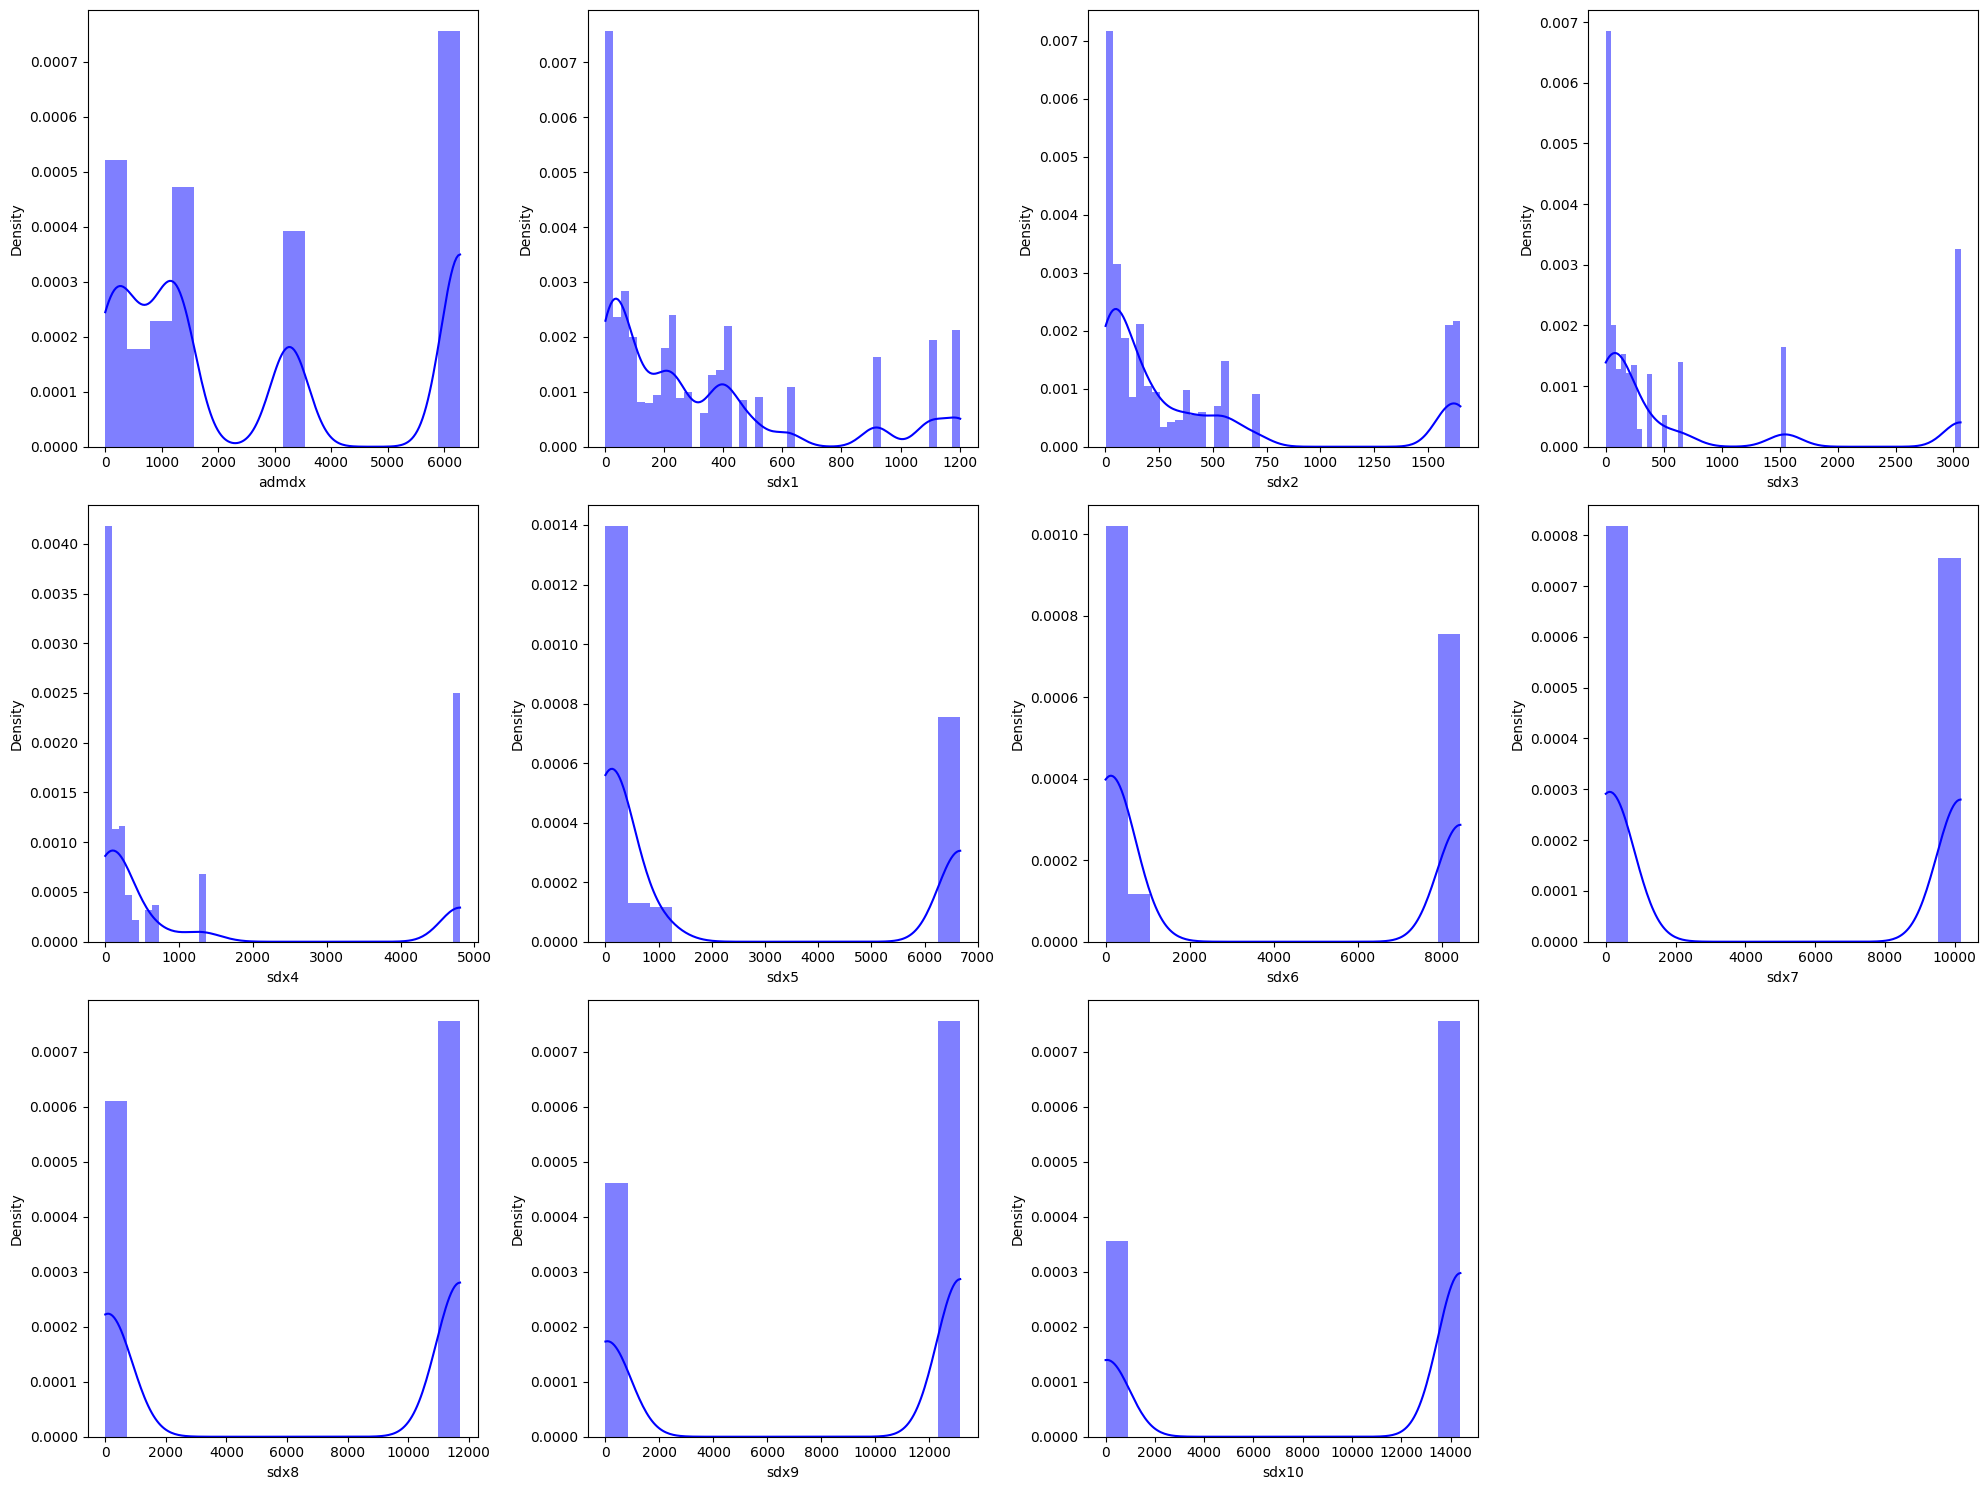

In [6]:
# checking numerical features distribution
plt.figure(figsize = (20, 15))
plotnumber = 1
for column in num_cols:
    if plotnumber <= 14:
        ax = plt.subplot(3, 4, plotnumber)
        sns.histplot (colectomy_cci_var[column], color = 'blue', kde = True, stat = "density", linewidth = 0)
        plt.xlabel(column)
    
        
    plotnumber += 1

plt.tight_layout()
plt.show()

/var/folders/cm/xf8t3rxj687fb5y5xqpyndrr0000gn/T/ipykernel_47178/1215541339.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = colectomy_cci_var[column], palette = 'deep', color = 'black', legend = False)
/var/folders/cm/xf8t3rxj687fb5y5xqpyndrr0000gn/T/ipykernel_47178/1215541339.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = colectomy_cci_var[column], palette = 'deep', color = 'black', legend = False)
/var/folders/cm/xf8t3rxj687fb5y5xqpyndrr0000gn/T/ipykernel_47178/1215541339.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.cou

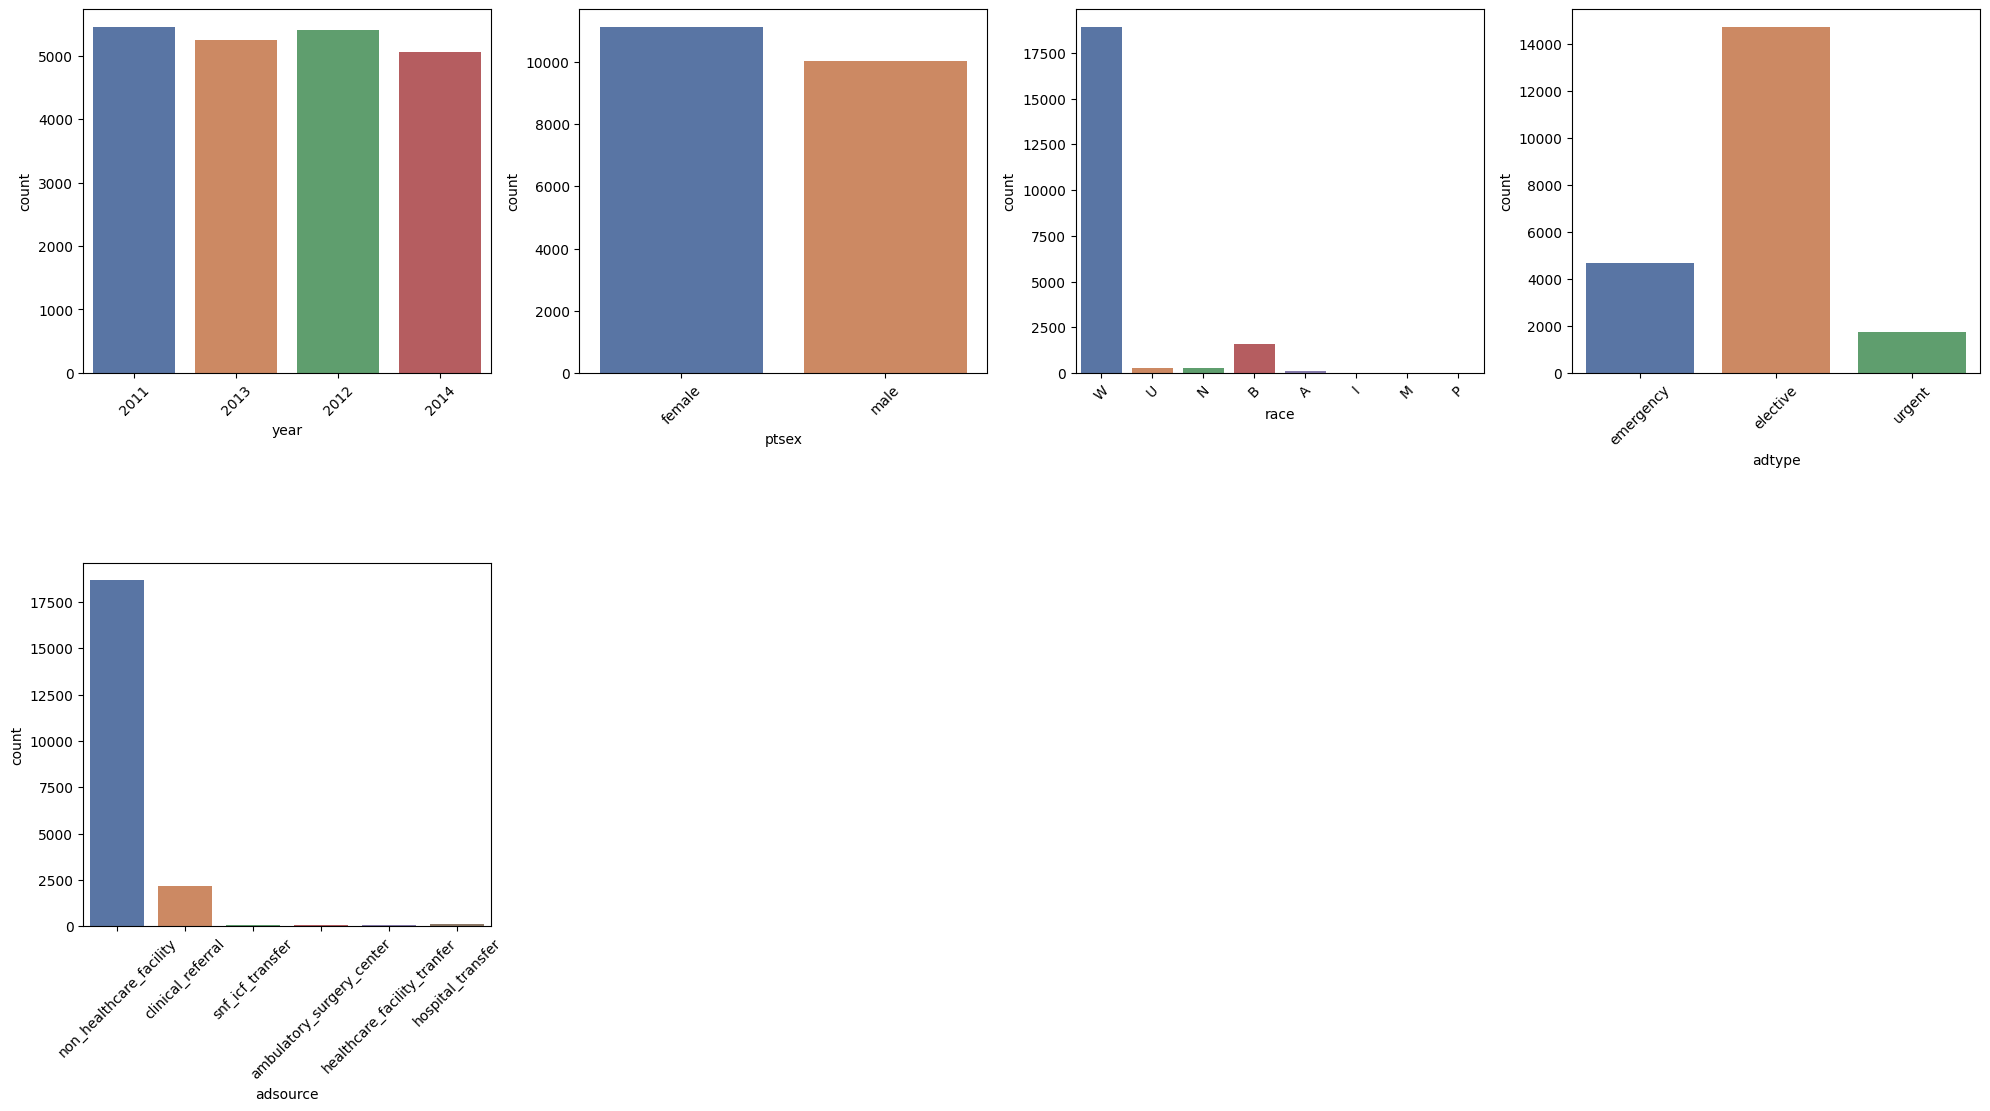

In [8]:
# looking at categorical columns

plt.figure(figsize = (20, 15))
plotnumber = 1
for column in cat_cols:
    if plotnumber <= 11:
        ax = plt.subplot(3, 4, plotnumber)
        sns.countplot(x = colectomy_cci_var[column], palette = 'deep', color = 'black', legend = False)
        plt.xlabel(column)
        plt.xticks(rotation = 45)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

In [22]:
colectomy_cci_var_X = colectomy_cci_var[features]
colectomy_cci_var_y = colectomy_cci_var['pdx']

# One-Hot Encoding
colectomy_cci_var_X = pd.get_dummies(colectomy_cci_var_X, columns = dummy_features, dtype = 'int')

# Split Data
train_X, test_X, train_y, test_y = train_test_split(colectomy_cci_var_X, colectomy_cci_var_y, test_size = 0.2, random_state = 0)

# Data Resampling
#smote = SMOTE(sampling_strategy = 'auto', random_state = 0)
#train_X, train_y = smote.fit_resample(train_X, train_y)

# Label Encoding
encoder = LabelEncoder()
label_encoder = encoder.fit(train_y)
train_y = label_encoder.transform(train_y)
test_y = label_encoder.transform(test_y)

# Normalize Data
normalize_features = list(set(features) - set(dummy_features))

scaler = MinMaxScaler()

train_X_normalized = train_X.copy()
test_X_normalzied = test_X.copy()

normalizer = scaler.fit(train_X_normalized[normalize_features])

train_X_normalized[normalize_features] = normalizer.transform(train_X_normalized[normalize_features])
test_X_normalzied[normalize_features] = normalizer.transform(test_X_normalzied[normalize_features])

In [ ]:
# Split the training set into Medicare, Medicaid, Government Health Insurance
#colectomy_cci_var_public = colectomy_cci_var[colectomy_cci_var['paytype1'].str.startswith(('1', '2', '8'))]
# Split the test set into Uninsured, Blue Cross, Commercial, leave out the Unknown insurance group
#colectomy_cci_var_private_other = colectomy_cci_var[colectomy_cci_var['paytype1'].str.startswith(('0', '3', '4'))]

# Split the training set into patients below the age of 60
colectomy_cci_var_public = colectomy_cci_var[colectomy_cci_var['age'] < 60]
# Split the testing set into patients above the age of 60
colectomy_cci_var_private_other = colectomy_cci_var[colectomy_cci_var['age'] >= 60]

print(f"Length of training set: {len(colectomy_cci_var_public)}")
print(f"Length of testing set: {len(colectomy_cci_var_private_other)}")

train_X_OOD = colectomy_cci_var_public[features]
train_y_OOD = colectomy_cci_var_public['pdx'] 
test_X_OOD = colectomy_cci_var_private_other[features]
test_y_OOD = colectomy_cci_var_private_other['pdx']

# One-Hot Encoding
train_X_OOD = pd.get_dummies(train_X_OOD, columns = dummy_features, dtype = 'int')
test_X_OOD = pd.get_dummies(test_X_OOD, columns = dummy_features, dtype = 'int')

# Data Resampling
# Change variable names to OOD if this gets used
#smote = SMOTE(sampling_strategy = 'auto', random_state = 0)
#train_X, train_y = smote.fit_resample(train_X, train_y)

# Label Encoding
encoder = LabelEncoder()
label_encoder = encoder.fit(train_y_OOD)
train_y_OOD = label_encoder.transform(train_y_OOD)
test_y_OOD = label_encoder.transform(test_y_OOD)

# Normalize Data
normalize_features = list(set(features) - set(dummy_features))

scaler = MinMaxScaler()

train_X_OOD_normalized = train_X_OOD.copy()
test_X_OOD_normalzied = test_X_OOD.copy()

normalizer = scaler.fit(train_X_OOD_normalized[normalize_features])

train_X_OOD_normalized[normalize_features] = normalizer.transform(train_X_OOD_normalized[normalize_features])
test_X_OOD_normalzied[normalize_features] = normalizer.transform(test_X_OOD_normalzied[normalize_features])

Length of training set: 7773
Length of testing set: 13397


In [24]:
X_train = train_X_normalized
X_test = test_X_normalzied
Y_train = train_y
Y_test = test_y

In [25]:
X_train_OOD = train_X_OOD_normalized
X_test_OOD = test_X_OOD_normalzied
Y_train_OOD = train_y_OOD
Y_test_OOD = test_y_OOD

# Training Models

In [11]:
# Random Forest
clf_rand_forest = RandomForestClassifier()
clf_rand_forest.fit(X_train, Y_train)

RandomForestClassifier()

In [12]:
# SVM
clf_svm = svm.SVC(kernel = 'linear')
clf_svm.fit(X_train, Y_train)

SVC(kernel='linear')

In [13]:
# Naive Bayes
clf_gnb = GaussianNB()
clf_gnb.fit(X_train, Y_train)

GaussianNB()

In [14]:
# Logistic Regression
clf_log = LogisticRegression(solver = 'lbfgs', max_iter = 2500)
clf_log.fit(X_train, Y_train)

LogisticRegression(max_iter=2500)

In [15]:
# KNN
clf_knn = KNeighborsClassifier(n_neighbors = 5)
clf_knn.fit(X_train, Y_train)

KNeighborsClassifier()

In [16]:
# XG Boost
clf_xgb = XGBClassifier(objective = 'multi:softmax', 
                        learning_rate = 0.5, 
                        max_depth = 5, 
                        n_estimators = 150, 
                        eval_metric = 'mlogloss',  
                        use_label_encoder = False)
clf_xgb.fit(X_train, Y_train)

/opt/anaconda3/envs/DS340W/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:11:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.5, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

In [17]:
# Decision Tree
clf_dtc = DecisionTreeClassifier()
clf_dtc.fit(X_train, Y_train)

DecisionTreeClassifier()

In [18]:
# Ada Boost
clf_ada = AdaBoostClassifier(estimator = clf_dtc)
clf_ada.fit(X_train, Y_train)

/opt/anaconda3/envs/DS340W/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier())

In [26]:
X_train

,admdx,sdx1,sdx2,sdx3,sdx4,sdx5,sdx6,sdx7,sdx8,sdx9,...,race_W,adtype_elective,adtype_emergency,adtype_urgent,adsource_ambulatory_surgery_center,adsource_clinical_referral,adsource_healthcare_facility_tranfer,adsource_hospital_transfer,adsource_non_healthcare_facility,adsource_snf_icf_transfer
30059,0.147523,0.002498,0.345245,0.035948,0.000416,0.009598,0.000592,0.003247,1.000000,1.000000,...,1,1,0,0,0,0,0,0,1,0
31921,1.000000,0.327227,0.419746,0.214052,0.036844,0.000300,1.000000,1.000000,1.000000,1.000000,...,1,1,0,0,0,0,0,0,1,0
19011,0.519038,0.005828,0.209570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1,1,0,0,0,0,0,0,1,0
16978,1.000000,1.000000,1.000000,0.160458,0.003747,0.024145,0.001065,0.000295,1.000000,1.000000,...,1,1,0,0,0,0,0,0,1,0
29569,0.042058,0.039967,0.093277,0.121569,0.018526,0.014697,0.091501,0.041724,0.012548,0.000152,...,1,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24162,0.155170,0.763530,1.000000,0.067974,0.146545,0.009748,0.012902,0.001870,0.001195,0.000532,...,1,1,0,0,0,0,0,0,1,0
35900,0.201370,0.033306,0.961841,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1,1,0,0,0,0,0,0,1,0
18018,0.155170,0.012490,0.122350,0.002941,0.000624,0.004799,0.008996,0.002067,1.000000,1.000000,...,0,1,0,0,0,0,0,0,1,0
19775,0.020551,0.763530,0.132647,0.080392,0.012906,0.005249,0.000000,0.003346,0.000000,0.001977,...,0,0,1,0,0,0,0,0,1,0


In [ ]:
# Model Architecture
class BayesianNeuralNetwork(nn.Module):
    def __init__(self, feature_size, num_classes):
        super().__init__()

        layer_1_size = 256
        layer_2_size = 256

        # Layers
        self.bayes_linear_1 = bnn.BayesLinear(prior_mu = 0, prior_sigma = 1, in_features = feature_size, out_features = layer_1_size)
        self.bayes_linear_2 = bnn.BayesLinear(prior_mu = 0, prior_sigma = 1, in_features = layer_1_size, out_features = layer_2_size)
        self.output_layer = nn.Linear(in_features = layer_2_size, out_features = num_classes)
    
    def forward(self, x):
        x = torch.relu(self.bayes_linear_1(x))
        x = torch.relu(self.bayes_linear_2(x))
        return self.output_layer(x)
    
# Loss Function
def elbo_loss(output, target, model):
    standard_loss = nn.CrossEntropyLoss()(output, target)
    kl_loss = bnn.BKLLoss(reduction = 'mean', last_layer_only = False)

    return standard_loss + kl_loss(model)

def train(model, train_loader, optimizer, epochs = 5):
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = elbo_loss(output, target, model)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1}, Loss: {loss.item()}")
        
        '''
        # After each epoch, evaluate on the validation set
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                val_loss += elbo_loss(output, target, model).item()

        # Calculate average validation loss
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

        # Save the model if it has improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # Save model parameters
            best_posterior = model
        '''

best_val_loss = float('inf')  # Initialize best validation loss to a high value
best_model_state = None  # To store the best model's state_dict
best_posterior = None

X_tensor = torch.tensor(X_train.values).float()
y_tensor = torch.tensor(pd.Series(Y_train).values).long()

dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size = 32, shuffle = True)

model = BayesianNeuralNetwork(feature_size = X_train.shape[1], num_classes = len(torch.unique(y_tensor)))
optimizer = optim.Adam(model.parameters(), lr = 0.001)
train(model, train_loader, optimizer, 20)

In [ ]:
# Sampling from posterior (to account for uncertainty in predictions)
num_samples = 100  # Number of posterior samples

model.eval()  # Set model to evaluation mode
outputs = []
with torch.no_grad():
    for _ in range(num_samples):
        output_sample = model(X_test)  # Forward pass with sampled weights
        outputs.append(output_sample)

# Now you have a list of outputs from each sample; you can compute statistics (mean, variance, etc.)
outputs = torch.stack(outputs)
mean_output = outputs.mean(dim=0)  # Mean over all samples (for classification, for example)
_, predicted_classes = torch.max(mean_output, 1)

print(predicted_classes)

# Training OOD Models

In [19]:
# Random Forest
clf_rand_forest_OOD = RandomForestClassifier()
clf_rand_forest_OOD.fit(X_train_OOD, Y_train_OOD)

RandomForestClassifier()

In [20]:
# SVM
clf_svm_OOD = svm.SVC(kernel = 'linear')
clf_svm_OOD.fit(X_train_OOD, Y_train_OOD)

SVC(kernel='linear')

In [21]:
# Naive Bayes
clf_gnb_OOD = GaussianNB()
clf_gnb_OOD.fit(X_train_OOD, Y_train_OOD)

GaussianNB()

In [22]:
# Logistic Regression
clf_log_OOD = LogisticRegression(solver = 'lbfgs', max_iter = 2500)
clf_log_OOD.fit(X_train_OOD, Y_train_OOD)

LogisticRegression(max_iter=2500)

In [23]:
# KNN
clf_knn_OOD = KNeighborsClassifier(n_neighbors = 5)
clf_knn_OOD.fit(X_train_OOD, Y_train_OOD)

KNeighborsClassifier()

In [24]:
# XG Boost
clf_xgb_OOD = XGBClassifier(objective = 'multi:softmax', 
                        learning_rate = 0.5, 
                        max_depth = 5, 
                        n_estimators = 150, 
                        eval_metric = 'mlogloss',  
                        use_label_encoder = False)
clf_xgb_OOD.fit(X_train_OOD, Y_train_OOD)

/opt/anaconda3/envs/DS340W/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:11:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.5, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

In [25]:
# Decision Tree
clf_dtc_OOD = DecisionTreeClassifier()
clf_dtc_OOD.fit(X_train_OOD, Y_train_OOD)

DecisionTreeClassifier()

In [26]:
# Ada Boost
clf_ada_OOD = AdaBoostClassifier(estimator = clf_dtc_OOD)
clf_ada_OOD.fit(X_train_OOD, Y_train_OOD)

/opt/anaconda3/envs/DS340W/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier())

# Evaluation

### Random Forest

#### Classification Report

In [27]:
Y_pred = clf_rand_forest.predict(X_test)

rand_forest_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {rand_forest_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.7194142654700048
Mean Absolute Error: 0.6258856872933396
Mean Squared Error: 1.7912139820500708
Classification Report: 
              precision    recall  f1-score   support

           0       0.45      0.14      0.21       240
           1       0.65      0.56      0.60       462
           2       0.44      0.46      0.45       454
           3       0.51      0.56      0.53       564
           4       0.82      0.83      0.83       740
           5       0.84      0.91      0.87      1774

    accuracy                           0.72      4234
   macro avg       0.62      0.58      0.58      4234
weighted avg       0.71      0.72      0.71      4234



### SVM

#### Classification Report

In [28]:
Y_pred = clf_svm.predict(X_test)

svm_acc = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {svm_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.6053377420878602
Mean Absolute Error: 0.8788379782711384
Mean Squared Error: 2.4489844119036372
Classification Report: 
              precision    recall  f1-score   support

           0       0.17      0.00      0.01       240
           1       0.31      0.38      0.34       462
           2       0.08      0.00      0.00       454
           3       0.28      0.50      0.36       564
           4       0.91      0.74      0.82       740
           5       0.76      0.88      0.81      1774

    accuracy                           0.61      4234
   macro avg       0.42      0.42      0.39      4234
weighted avg       0.57      0.61      0.57      4234



### Naive Bayes

#### Classification Report

In [29]:
Y_pred = clf_gnb.predict(X_test)

gnb_acc = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {gnb_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.47850732168162496
Mean Absolute Error: 0.9924421350968351
Mean Squared Error: 2.3925366084081245
Classification Report: 
              precision    recall  f1-score   support

           0       0.08      0.05      0.06       240
           1       0.13      0.02      0.03       462
           2       0.18      0.80      0.30       454
           3       1.00      0.00      0.00       564
           4       0.54      0.56      0.55       740
           5       0.93      0.69      0.80      1774

    accuracy                           0.48      4234
   macro avg       0.48      0.35      0.29      4234
weighted avg       0.66      0.48      0.47      4234



### Logistic Regression

#### Classification Report

In [30]:
Y_pred = clf_log.predict(X_test)

log_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {log_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.5136986301369864
Mean Absolute Error: 0.9962210675484175
Mean Squared Error: 2.6121870571563535
Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       240
           1       0.18      0.09      0.12       462
           2       0.24      0.16      0.19       454
           3       0.25      0.29      0.27       564
           4       0.39      0.52      0.45       740
           5       0.73      0.85      0.79      1774

    accuracy                           0.51      4234
   macro avg       0.30      0.32      0.30      4234
weighted avg       0.45      0.51      0.48      4234



### KNN

#### Classification Report

In [31]:
Y_pred = clf_knn.predict(X_test)

knn_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {knn_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.5344827586206896
Mean Absolute Error: 1.005196032120926
Mean Squared Error: 2.8138875767595652
Classification Report: 
              precision    recall  f1-score   support

           0       0.15      0.17      0.16       240
           1       0.23      0.29      0.26       462
           2       0.21      0.21      0.21       454
           3       0.25      0.23      0.24       564
           4       0.66      0.66      0.66       740
           5       0.82      0.77      0.80      1774

    accuracy                           0.53      4234
   macro avg       0.39      0.39      0.39      4234
weighted avg       0.55      0.53      0.54      4234



### XG_Boost

#### Classification Report

In [32]:
Y_pred = clf_xgb.predict(X_test)

xgb_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {xgb_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.7907416154936231
Mean Absolute Error: 0.41591875295229097
Mean Squared Error: 1.0748700991969768
Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.47      0.56       240
           1       0.70      0.61      0.65       462
           2       0.56      0.54      0.55       454
           3       0.59      0.60      0.59       564
           4       0.82      0.88      0.85       740
           5       0.92      0.97      0.94      1774

    accuracy                           0.79      4234
   macro avg       0.72      0.68      0.69      4234
weighted avg       0.78      0.79      0.79      4234



### Decision Tree

#### Classification Report

In [33]:
Y_pred = clf_dtc.predict(X_test)

dtc_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {dtc_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.7347661785545584
Mean Absolute Error: 0.5824279641001417
Mean Squared Error: 1.6476145488899385
Classification Report: 
              precision    recall  f1-score   support

           0       0.44      0.46      0.45       240
           1       0.58      0.60      0.59       462
           2       0.52      0.53      0.52       454
           3       0.56      0.56      0.56       564
           4       0.77      0.77      0.77       740
           5       0.92      0.90      0.91      1774

    accuracy                           0.73      4234
   macro avg       0.63      0.64      0.63      4234
weighted avg       0.74      0.73      0.74      4234



### Ada Boost

#### Classification Report

In [34]:
Y_pred = clf_ada.predict(X_test)

ada_acc = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {ada_acc}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test, Y_pred, zero_division = 1)}")

Accuracy: 0.7418516769012754
Mean Absolute Error: 0.5632971185640057
Mean Squared Error: 1.5788852149267831
Classification Report: 
              precision    recall  f1-score   support

           0       0.47      0.45      0.46       240
           1       0.61      0.61      0.61       462
           2       0.51      0.53      0.52       454
           3       0.57      0.56      0.56       564
           4       0.78      0.80      0.79       740
           5       0.91      0.91      0.91      1774

    accuracy                           0.74      4234
   macro avg       0.64      0.64      0.64      4234
weighted avg       0.74      0.74      0.74      4234



# Model Comparison

In [35]:
models = pd.DataFrame({
    'Model' : [ 'Random Forest Classifier', 'SVM Classifier', 'Naive Bayes Classifier','KNN Classifier', 'XG_Boost Classifier', 'Decision Tree Classifier', 'Ada_Boost Classifier'],
    'Score' : [rand_forest_acc, svm_acc, gnb_acc, knn_acc, xgb_acc, dtc_acc, ada_acc]
})

sorted_models = models.sort_values(by = 'Score', ascending = True)

fig = px.bar(data_frame = sorted_models, x = 'Score', y = 'Model', title = 'Models Comparison')

fig.show()

In [36]:
Y_pred = clf_rand_forest_OOD.predict(X_test_OOD)

rand_forest_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {rand_forest_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.5738598193625438
Mean Absolute Error: 1.0503097708442188
Mean Squared Error: 3.2522952899902964
Classification Report: 
              precision    recall  f1-score   support

           0       0.33      0.03      0.05       972
           1       0.40      0.53      0.46      1536
           2       0.56      0.16      0.24      1880
           3       0.63      0.22      0.33      2295
           4       0.75      0.80      0.78      2686
           5       0.55      0.96      0.70      4028

    accuracy                           0.57     13397
   macro avg       0.54      0.45      0.43     13397
weighted avg       0.57      0.57      0.51     13397



In [37]:
Y_pred = clf_svm_OOD.predict(X_test_OOD)

svm_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {svm_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.4886914980965888
Mean Absolute Error: 1.180786743300739
Mean Squared Error: 3.422482645368366
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       972
           1       0.20      0.65      0.30      1536
           2       1.00      0.00      0.00      1880
           3       1.00      0.00      0.00      2295
           4       0.89      0.72      0.80      2686
           5       0.58      0.90      0.71      4028

    accuracy                           0.49     13397
   macro avg       0.78      0.38      0.30     13397
weighted avg       0.76      0.49      0.41     13397



In [38]:
Y_pred = clf_gnb_OOD.predict(X_test_OOD)

gnb_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {gnb_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.1660819586474584
Mean Absolute Error: 1.876091662312458
Mean Squared Error: 6.149137866686572
Classification Report: 
              precision    recall  f1-score   support

           0       0.02      0.05      0.03       972
           1       0.18      0.01      0.03      1536
           2       0.22      0.70      0.34      1880
           3       0.19      0.33      0.24      2295
           4       0.01      0.00      0.00      2686
           5       1.00      0.02      0.04      4028

    accuracy                           0.17     13397
   macro avg       0.27      0.19      0.11     13397
weighted avg       0.39      0.17      0.11     13397



In [39]:
Y_pred = clf_log_OOD.predict(X_test_OOD)

log_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {log_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.3196237963723222
Mean Absolute Error: 1.4051653355228784
Mean Squared Error: 3.840188101813839
Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       972
           1       0.15      0.27      0.19      1536
           2       0.30      0.01      0.02      1880
           3       0.24      0.02      0.03      2295
           4       0.10      0.10      0.10      2686
           5       0.45      0.88      0.60      4028

    accuracy                           0.32     13397
   macro avg       0.21      0.21      0.16     13397
weighted avg       0.26      0.32      0.23     13397



In [40]:
Y_pred = clf_knn_OOD.predict(X_test_OOD)

knn_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {knn_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.42703590356049864
Mean Absolute Error: 1.3250727774874973
Mean Squared Error: 3.893110397850265
Classification Report: 
              precision    recall  f1-score   support

           0       0.12      0.08      0.10       972
           1       0.18      0.33      0.24      1536
           2       0.24      0.08      0.12      1880
           3       0.28      0.11      0.16      2295
           4       0.60      0.52      0.56      2686
           5       0.55      0.82      0.66      4028

    accuracy                           0.43     13397
   macro avg       0.33      0.33      0.31     13397
weighted avg       0.40      0.43      0.39     13397



In [41]:
Y_pred = clf_xgb_OOD.predict(X_test_OOD)

xgb_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {xgb_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.7315816973949392
Mean Absolute Error: 0.5656490259013212
Mean Squared Error: 1.5395984175561692
Classification Report: 
              precision    recall  f1-score   support

           0       0.72      0.48      0.57       972
           1       0.53      0.64      0.58      1536
           2       0.68      0.48      0.56      1880
           3       0.72      0.52      0.60      2295
           4       0.79      0.88      0.83      2686
           5       0.79      0.97      0.87      4028

    accuracy                           0.73     13397
   macro avg       0.70      0.66      0.67     13397
weighted avg       0.73      0.73      0.72     13397



In [42]:
Y_pred = clf_dtc_OOD.predict(X_test_OOD)

dtc_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {dtc_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.6817944315891618
Mean Absolute Error: 0.6794804807046354
Mean Squared Error: 1.888407852504292
Classification Report: 
              precision    recall  f1-score   support

           0       0.52      0.49      0.50       972
           1       0.51      0.60      0.55      1536
           2       0.56      0.48      0.52      1880
           3       0.60      0.52      0.56      2295
           4       0.75      0.79      0.77      2686
           5       0.83      0.88      0.85      4028

    accuracy                           0.68     13397
   macro avg       0.63      0.62      0.62     13397
weighted avg       0.68      0.68      0.68     13397



In [43]:
Y_pred = clf_ada_OOD.predict(X_test_OOD)

ada_acc_OOD = accuracy_score(Y_test_OOD, Y_pred)

print(f"Accuracy: {ada_acc_OOD}")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_OOD, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(Y_test_OOD, Y_pred)}")
print(f"Classification Report: \n{classification_report(Y_test_OOD, Y_pred, zero_division = 1)}")

Accuracy: 0.682242293050683
Mean Absolute Error: 0.6791819063969545
Mean Squared Error: 1.8824363663506756
Classification Report: 
              precision    recall  f1-score   support

           0       0.58      0.47      0.52       972
           1       0.48      0.62      0.54      1536
           2       0.57      0.47      0.52      1880
           3       0.62      0.51      0.56      2295
           4       0.76      0.78      0.77      2686
           5       0.81      0.89      0.85      4028

    accuracy                           0.68     13397
   macro avg       0.64      0.62      0.63     13397
weighted avg       0.68      0.68      0.68     13397



In [44]:
models = pd.DataFrame({
    'Model' : [ 'Random Forest Classifier', 'SVM Classifier', 'Naive Bayes Classifier','KNN Classifier', 'XG_Boost Classifier', 'Decision Tree Classifier', 'Ada_Boost Classifier'],
    'Score' : [rand_forest_acc_OOD, svm_acc_OOD, gnb_acc_OOD, knn_acc_OOD, xgb_acc_OOD, dtc_acc_OOD, ada_acc_OOD]
})

sorted_models = models.sort_values(by = 'Score', ascending = True)

fig = px.bar(data_frame = sorted_models, x = 'Score', y = 'Model', title=  'Models Comparison')

fig.show()

In [45]:
importances = clf_rand_forest_OOD.feature_importances_

# Sort and display feature importances
sorted_idx = importances.argsort()
for idx in sorted_idx:
    print(f"Feature: {X_train.columns[idx]}, Importance: {importances[idx]}")

Feature: adsource_snf_icf_transfer, Importance: 0.00010110578295455266
Feature: race_M, Importance: 0.00013976469859768302
Feature: race_P, Importance: 0.0001438872893073924
Feature: race_I, Importance: 0.00022501759237318505
Feature: adsource_healthcare_facility_tranfer, Importance: 0.00040720015425988176
Feature: adsource_ambulatory_surgery_center, Importance: 0.00041072964997422123
Feature: adsource_hospital_transfer, Importance: 0.0008306809538980948
Feature: race_A, Importance: 0.0013499187357572432
Feature: race_U, Importance: 0.0022857764940396566
Feature: race_N, Importance: 0.0024545937090144337
Feature: adtype_urgent, Importance: 0.004068622065049251
Feature: adsource_clinical_referral, Importance: 0.006148066378257995
Feature: adsource_non_healthcare_facility, Importance: 0.006552838600534443
Feature: race_B, Importance: 0.006714555698372217
Feature: race_W, Importance: 0.008074257112557222
Feature: ptsex_female, Importance: 0.008562566473366926
Feature: ptsex_male, Importan

In [46]:
models = [ 'Random Forest Classifier', 'SVM Classifier', 'Naive Bayes Classifier','KNN Classifier', 'XG_Boost Classifier', 'Decision Tree Classifier', 'Ada_Boost Classifier']
ID_accuracies = [rand_forest_acc, svm_acc, gnb_acc, knn_acc, xgb_acc, dtc_acc, ada_acc]
OOD_accuracies = [rand_forest_acc_OOD, svm_acc_OOD, gnb_acc_OOD, knn_acc_OOD, xgb_acc_OOD, dtc_acc_OOD, ada_acc_OOD]

for i in range(len(models)):
    difference = ID_accuracies[i] - OOD_accuracies[i]
    print(f"{models[i]} Difference: {difference}")

Random Forest Classifier Difference: 0.14555444610746093
SVM Classifier Difference: 0.11664624399127138
Naive Bayes Classifier Difference: 0.31242536303416657
KNN Classifier Difference: 0.10744685506019097
XG_Boost Classifier Difference: 0.05915991809868393
Decision Tree Classifier Difference: 0.05297174696539664
Ada_Boost Classifier Difference: 0.059609383850592446
